In [1]:
import time
from itertools import product

import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
import vectorbtpro as vbt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This is the number of days we'll look back to 
# calculate the rolling z-score.
window = 22

# This is the number of standard deviations the 
# z-score needs to be above or below to trigger
# a trading signal.
thresh = 2
upper_threshold = 1.8
lower_threshold = -2

# Set the end date to today.
end = pd.Timestamp.today().strftime("%Y-%m-%d")

In [103]:
long_entry = -2
long_exit = 2
short_entry = 1.7
short_exit = 1.5

In [104]:
# Paramaterize the refiner symbol to easily swap
# them out.
refiner_symbol = "VLO"

In [105]:
# Use the VectorBT data download functionality to
# grab price history data.
data = vbt.YFData.pull(
    [
        "CL=F", 
        "RB=F", 
        "HO=F", 
        refiner_symbol
    ], 
    start="2020", 
    end=end,
    missing_index="drop"
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [106]:
# The data object requires us to extract the data.
cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
refiner = data.get("Close")[refiner_symbol]

In [107]:
type(data)

vectorbtpro.data.custom.yf.YFData

In [108]:
# Construct the crack spread which is defined as
# long one heating oil contract, long two gasoline
# contracts, and short three crude oil contracts.
crack_spread = 42 * (2 * rb + 1 * ho) - 3 * cl

In [109]:
crack_spread

Date
2020-01-02 00:00:00-05:00    44.625004
2020-01-03 00:00:00-05:00    44.328003
2020-01-06 00:00:00-05:00    42.983401
2020-01-07 00:00:00-05:00    41.925596
2020-01-08 00:00:00-05:00    41.913599
                               ...    
2024-02-28 00:00:00-05:00    66.792586
2024-02-29 00:00:00-05:00    71.500799
2024-03-01 00:00:00-05:00    93.275990
2024-03-04 00:00:00-05:00    92.161214
2024-03-05 00:00:00-05:00    87.778188
Length: 1050, dtype: float64

In [110]:
type(data)

vectorbtpro.data.custom.yf.YFData

In [111]:
type(data.data)

vectorbtpro.data.base.symbol_dict

In [112]:
vbt.Data.from_data(vbt.merge_dicts(data.data, data.data))

In [113]:
# crack_spread.plot(label='Crack Spread')
# refiner.plot(label='Refiner')
# plt.legend()
# plt.show()


<Axes: xlabel='Date'>

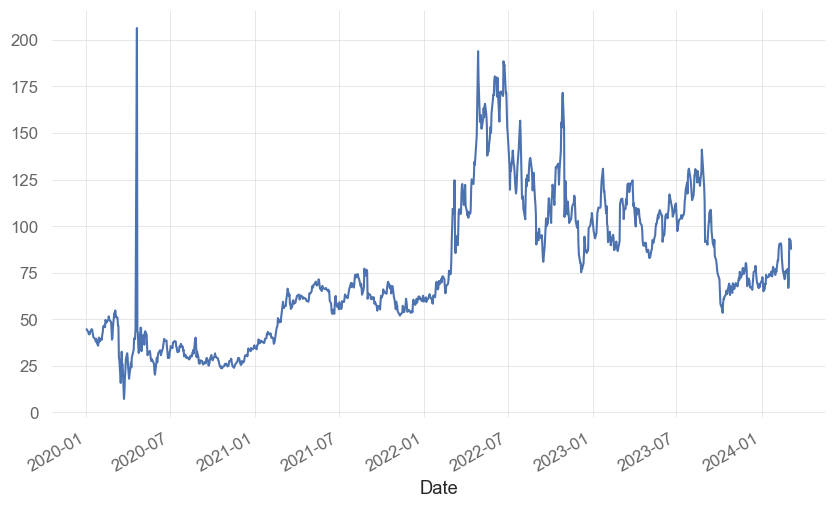

In [114]:
# Plot it.
crack_spread.plot()

In [115]:
# Now use the percentile rank to normalize the spread so we can
# compare it to the refiner stock
crack_spread_rank = crack_spread.rolling(window).rank(pct=True)

<Axes: xlabel='Date'>

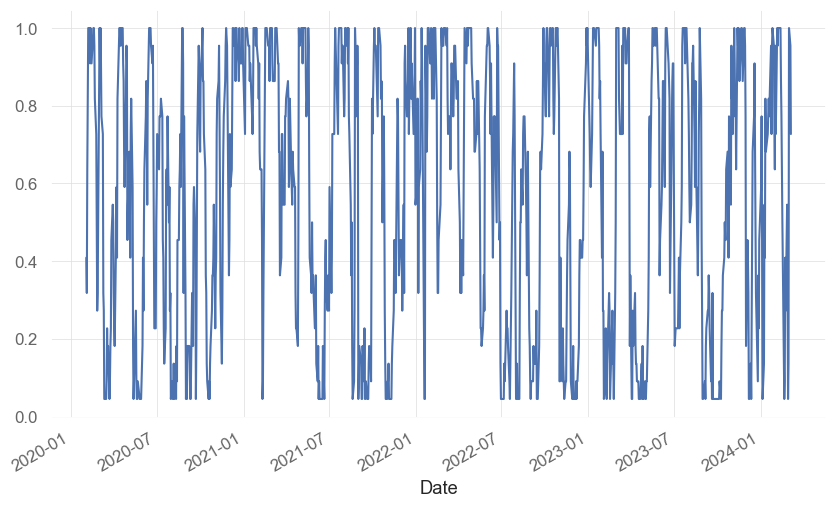

In [116]:
# Plot it.
crack_spread_rank.plot()

In [117]:
# Compute the percentile rank for the refiner's price
refiner_rank = refiner.rolling(window).rank(pct=True)

<Axes: xlabel='Date'>

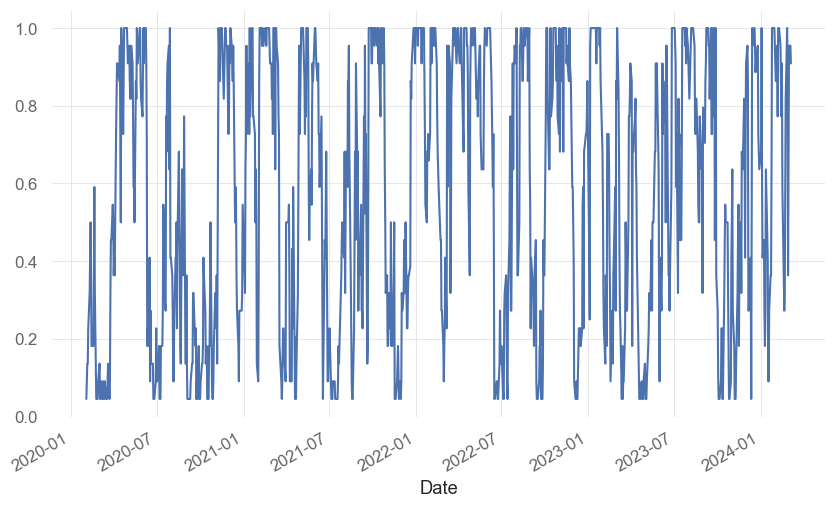

In [118]:
# Plot it.
refiner_rank.plot()

In [119]:
# Now compare the difference between the price performance by
# subtracting the rank
rank_spread = refiner_rank - crack_spread_rank

<Axes: xlabel='Date'>

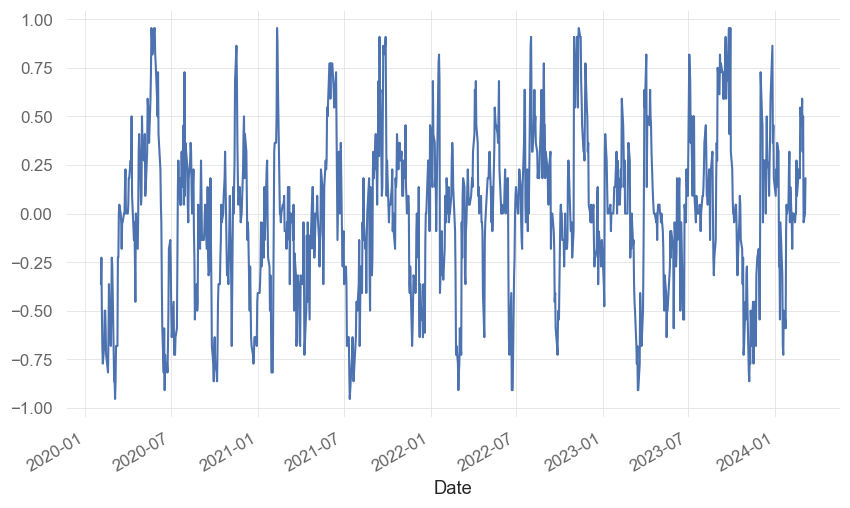

In [120]:
# Plot it.
rank_spread.plot()

In [121]:
# Normalize the difference by taking the z-score which forms our
# trading signal.
roll = rank_spread.rolling(window)
zscore = ((rank_spread - roll.mean()) / roll.std())

<Axes: xlabel='Date'>

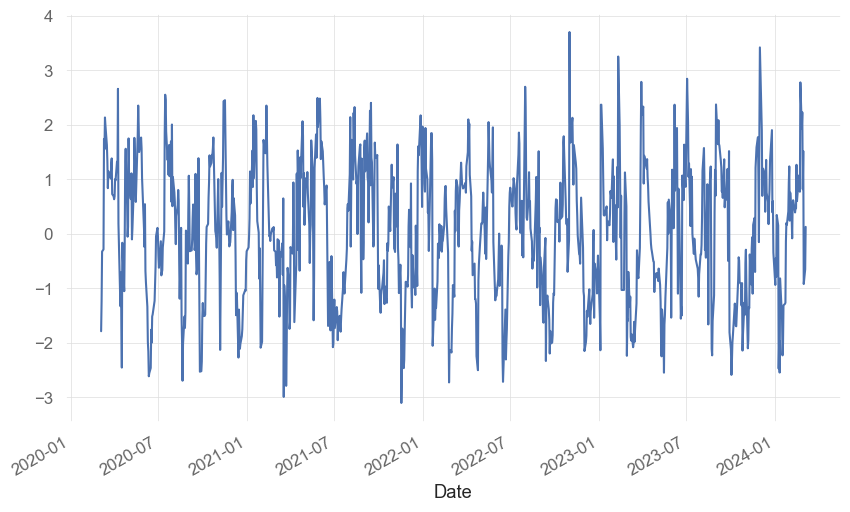

In [122]:
# Plot it.
zscore.plot()

In [123]:
# Find all occurences where the z-score crosses below the lower
# threshold and get long. Then set an exit when the z-score crosses
# above -1. Filter out all entry signals if the position has already 
# been entered, and exit signals if the position has already been exited.
long_entries = zscore.vbt.crossed_below(long_entry)  # long entries
long_exits = zscore.vbt.crossed_above(long_exit)
clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)

In [124]:
# Visualize long entries and exists
fig = zscore.vbt.plot()
clean_long_entries.vbt.signals.plot_as_entries(zscore, fig=fig)
clean_long_exits.vbt.signals.plot_as_exits(zscore, fig=fig)
fig.add_hline(y=long_exit, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=long_entry, line_color="limegreen", line_dash="dot")
fig.show()

In [125]:
# Find all occurences where the z-score crosses above the upper
# threshold and get short. Then set an exit when the z-score crosses
# below 1. Filter out all entry signals if the position has already 
# been entered, and exit signals if the position has already been exited.
short_entries = zscore.vbt.crossed_above(short_entry)  # short entries
short_exits = zscore.vbt.crossed_below(short_exit)
clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)

In [126]:
# Visualize short entries and exists
fig = zscore.vbt.plot()
clean_short_entries.vbt.signals.plot_as_exits(zscore, fig=fig)
clean_short_exits.vbt.signals.plot_as_entries(zscore, fig=fig)
fig.add_hline(y=short_exit, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=short_entry, line_color="limegreen", line_dash="dot")
fig.show()

In [131]:
# Run a backtest based on the closing price of the refiner using the z-score of the
# spread between the percentile rank of refiner and the crack spread as the
# entry and exit signals. Trade 10 shares and start with 25K.
pf = vbt.Portfolio.from_signals(
    close=refiner,
    entries=clean_long_entries,
    exits=clean_long_exits,
    short_entries=clean_short_entries,  # if you want to go short
    short_exits=clean_short_exits,  # if you want to go short
    size=1.0,  # 10% invested
    size_type="percent",
    init_cash=100_000,
    freq="1D"
)

In [132]:
# Print out the summary stats from the initial backtest.
pf.stats()

Start                          2020-01-02 00:00:00-05:00
End                            2024-03-05 00:00:00-05:00
Period                                1050 days 00:00:00
Start Value                                     100000.0
Min Value                                       100000.0
Max Value                                  289458.446039
End Value                                  288378.610796
Total Return [%]                              188.378611
Benchmark Return [%]                           83.943211
Total Time Exposure [%]                        50.666667
Max Gross Exposure [%]                        120.576123
Max Drawdown [%]                               44.146871
Max Drawdown Duration                  492 days 00:00:00
Total Orders                                         112
Total Fees Paid                                      0.0
Total Trades                                          65
Win Rate [%]                                   64.615385
Best Trade [%]                 

In [133]:
# Plot charts of orders along, trades, and cumulative returns.
pf.plot(settings=dict(bm_returns=False)).show()

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-03-11   2020-03-11
End Period                 2024-03-05   2024-03-05
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       53.0%

Cumulative Return          186.11%      188.38%
CAGR﹪                     19.97%       20.13%

Sharpe                     0.92         1.11
Prob. Sharpe Ratio         93.98%       96.96%
Smart Sharpe               0.89         1.06
Sortino                    1.41         1.75
Smart Sortino              1.36         1.68
Sortino/√2                 1.0          1.24
Smart Sortino/√2           0.96         1.19
Omega                      1.25         1.25

Max Drawdown               -51.29%      -44.15%
Longest DD Days            256          710
Volatility (ann.)          62.21%       43.12%
R^2                        0.1          0.1
Information Ratio          -0.01        -0.01
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-05-20,2021-07-19,2022-04-29,710,-44.146871,-41.449826
2,2022-05-27,2022-07-14,2023-04-03,312,-23.712059,-22.493320
3,2023-09-06,2023-11-09,2024-03-05,182,-20.038573,-18.204900
4,2022-05-09,2022-05-09,2022-05-17,9,-8.306240,-6.355474
5,2020-03-13,2020-03-13,2020-03-13,1,-7.720291,NaN


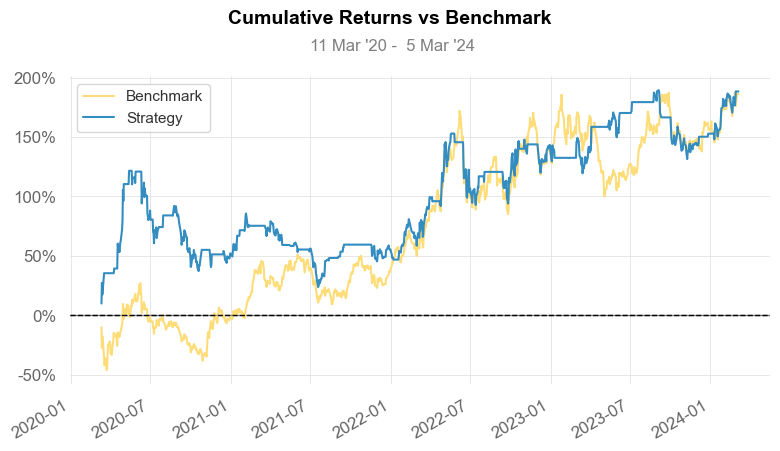

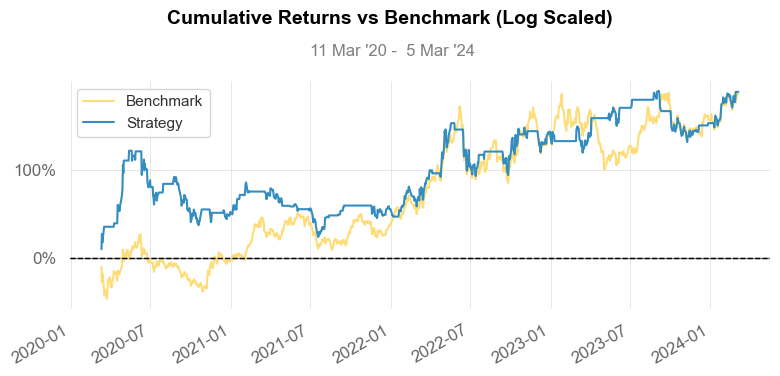

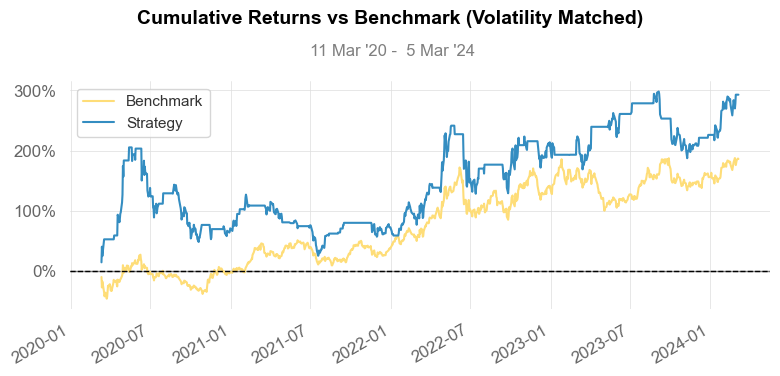

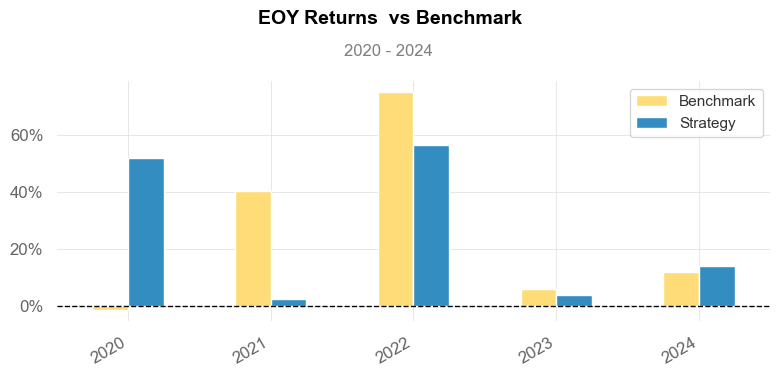

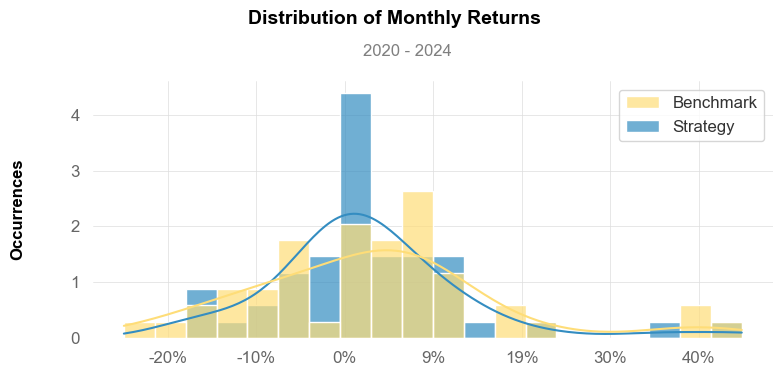

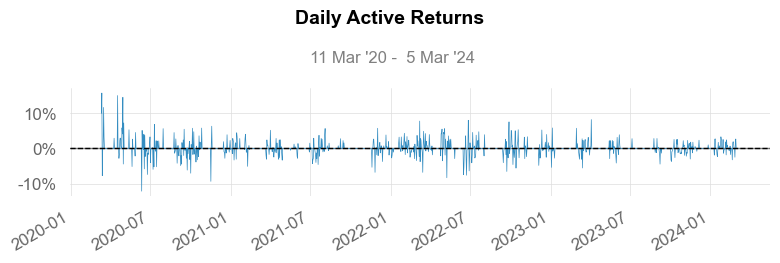

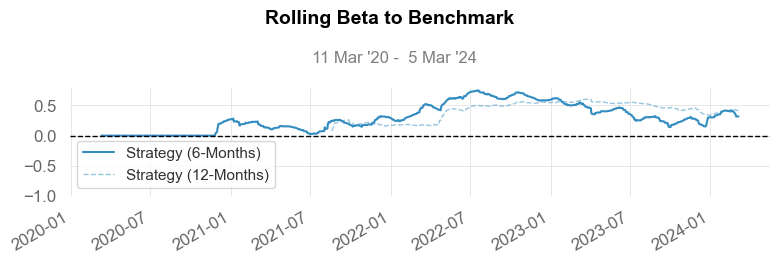

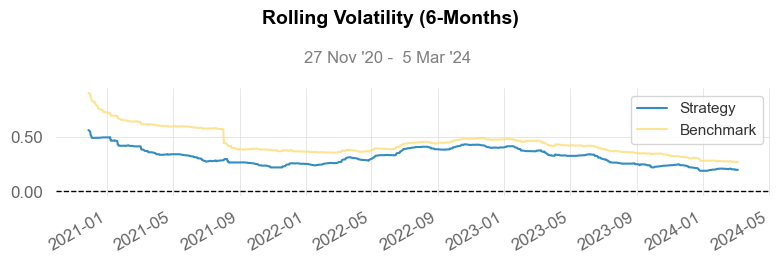

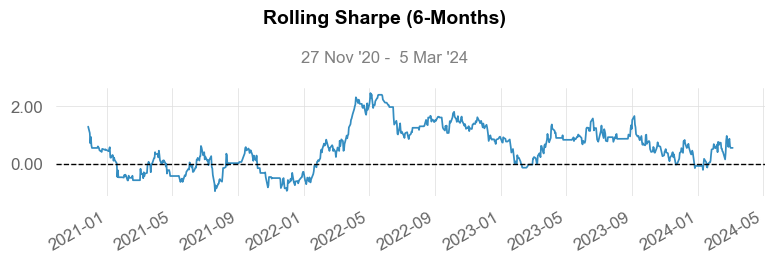

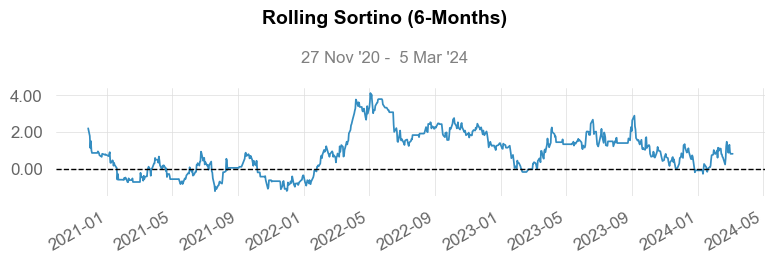

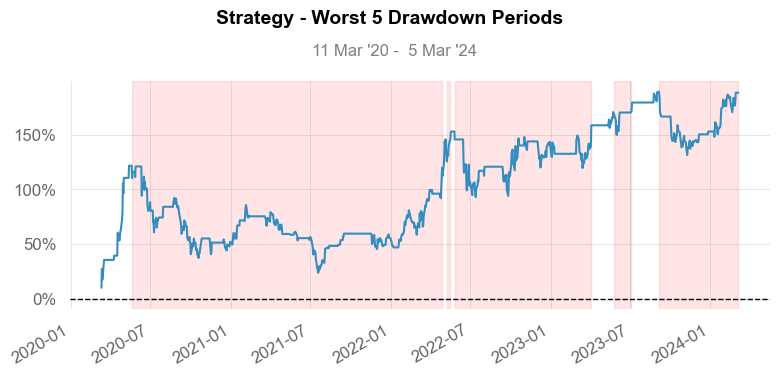

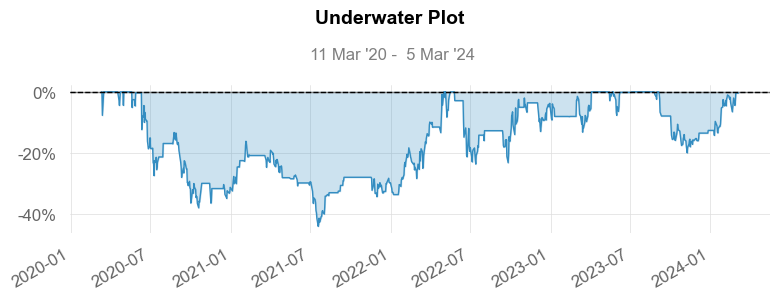

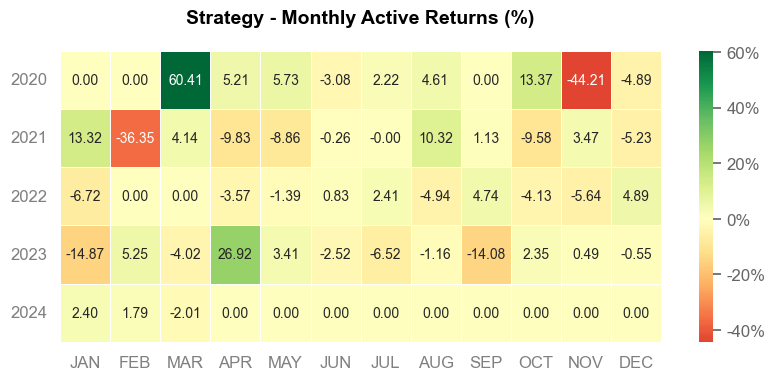

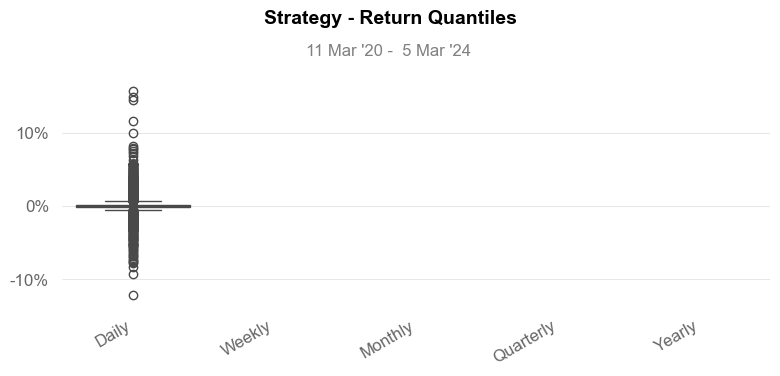

In [134]:
# Generate a Quantstats report.
pf.qs.full_report()

# Time to optimize

In [93]:
# Generate a function that accepts the parameters we want to optimize.
# In our case they are the entry and exit thresholds. The rest of the
# code is the same as before.
def test_strat(entry_th=2, exit_th=0):
    
    # Generate long entries
    long_entries = zscore.vbt.crossed_below(entry_th)  # long entries
    long_exits = zscore.vbt.crossed_above(exit_th)
    clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)
    
    # Generate short entries
    short_entries = zscore.vbt.crossed_above(entry_th)  # short entries
    short_exits = zscore.vbt.crossed_below(exit_th)
    clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)
    
    # Run the backtest
    pf = vbt.Portfolio.from_signals(
        close=refiner,
        # entries=clean_long_entries,
        # exits=clean_long_exits,
        short_entries=clean_short_entries,  # if you want to go short
        short_exits=clean_short_exits,  # if you want to go short
        size=1.0,  # Fully invested
        size_type="percent",
        init_cash=25_000,
        freq="1D"
    )

    return pf.stats([
        "total_return",
        "total_trades",
        "win_rate",
        "expectancy"
    ])
    


In [94]:
# Run the function with the defaults to return the total return,
# total trade count, win rate, and expectancy.
test_strat()

Total Return [%]     -25.17233
Total Trades                24
Win Rate [%]         45.833333
Expectancy         -262.211774
dtype: object

In [95]:
# Generate a range of entry and exit threholds between 0.01 and 3.4.
entry_th = [i / 10 for i in range(-35, 35)]
exit_th = [i / 10 for i in range(-35, 35)]

In [96]:
# Combine the thresholds together into a list of tuples that contain
# every combination of entry and exit thresholds. There are 1156
# different combinations we'll backtest.
th_combs = list(product(entry_th, exit_th))
len(th_combs)

4900

In [97]:
# Run all the different combinations of strategies to find the optimal
# combination of entry and exit thresholds. This takes about 30 seconds.
start_time = time.time()
comb_stats = [
    test_strat(entry_th=entry_th, exit_th=exit_th)
    for entry_th, exit_th in th_combs
]
print(f"Run took ~{int(time.time() - start_time)} seconds")

Run took ~1224 seconds


In [98]:
# Convert the backtest combinations from a list to a DataFrame with 
# metrics arranged as columns:
comb_stats_df = pd.DataFrame(comb_stats)
comb_stats_df

,Total Return [%],Total Trades,Win Rate [%],Expectancy
0,0.00000,0,NaN,NaN
1,0.00000,0,NaN,NaN
2,0.00000,0,NaN,NaN
3,0.00000,0,NaN,NaN
4,0.00000,0,NaN,NaN
...,...,...,...,...
4895,3.14237,2,50.0,392.796233
4896,3.14237,2,50.0,392.796233
4897,3.14237,2,50.0,392.796233
4898,3.14237,2,50.0,392.796233


In [99]:
# Build a MultiIndex DataFrame with two levels, entry_th and exit_th, 
# and make it the index of comb_stats_df. This aligns each run with 
# that run's statistics.
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs, 
    names=['entry_th', 'exit_th']
)
comb_stats_df

Total Return [%]  Total Trades  Win Rate [%]  Expectancy
entry_th exit_th                                                          
-3.5     -3.5              0.00000             0           NaN         NaN
         -3.4              0.00000             0           NaN         NaN
         -3.3              0.00000             0           NaN         NaN
         -3.2              0.00000             0           NaN         NaN
         -3.1              0.00000             0           NaN         NaN
...                            ...           ...           ...         ...
 3.4      3.0              3.14237             2          50.0  392.796233
          3.1              3.14237             2          50.0  392.796233
          3.2              3.14237             2          50.0  392.796233
          3.3              3.14237             2          50.0  392.796233
          3.4              3.14237             2          50.0  392.796233

[4900 rows x 4 columns]

In [100]:
# Plot a heatmap to see where our parameter combinations 
# perform well.
comb_stats_df['Total Return [%]'].vbt.heatmap().show()

In [101]:
# Find the paramter combination that maximizes the in sample
# return
total_returns = comb_stats_df['Total Return [%]']
max_total_return = comb_stats_df['Total Return [%]'].max()
comb_stats_df[total_returns == max_total_return]

,,Total Return [%],Total Trades,Win Rate [%],Expectancy
entry_th,exit_th,,,,
0.6,0.9,97.716527,77,67.532468,317.26145


In [102]:
# And run the strategy with these results.
test_strat(1.7, -1.5)

Total Return [%]   -51.662237
Total Trades               22
Win Rate [%]        28.571429
Expectancy         -603.71244
dtype: object